In [2]:
# === Manejo de datos ===
import pandas as pd
import numpy as np
import os
import io
import unicodedata
from io import StringIO

# === Visualización ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Modelado y estadística ===
import statsmodels.api as sm
from scipy.stats import ttest_ind
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# === Machine Learning ===
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    f1_score
)

In [3]:
os.chdir("/Users/matildecuenya/Library/Mobile Documents/com~apple~CloudDocs/Downloads/U. San Andres/2025/SEGUNDO CUATRIMESTRE/Ciencia de datos/TP EPH")

In [4]:
# Cargar las bases de datos
df_2005 = pd.read_stata("Individual_t105.dta")
df_2025 = pd.read_excel("usu_individual_T125.xlsx")

# Homogenizar los nombres de las columnas
df_2005.columns = df_2005.columns.str.upper()
df_2025.columns = df_2025.columns.str.upper()

# Columnas presentes en ambas bases de datos
columnas_comunes = df_2005.columns.intersection(df_2025.columns)

# Filtrar solo Región Pampeana
df_2025["REGION"] = df_2025["REGION"].replace({43: "Pampeana"})
df_2005_pampeana = df_2005[df_2005["REGION"] == "Pampeana"].copy()
df_2025_pampeana = df_2025[df_2025["REGION"] == "Pampeana"].copy()

# Agregar variable de año 
df_2005_pampeana["ANO4"] = 2005
df_2025_pampeana["ANO4"] = 2025

# Unir en una sola base 
df_final = pd.concat([df_2005_pampeana, df_2025_pampeana], ignore_index=True)
df_final

,CODUSU,NRO_HOGAR,COMPONENTE,H15,ANO4,TRIMESTRE,REGION,MAS_500,AGLOMERADO,PONDERA,...,V21_03_M,V22_01_M,V22_02_M,V22_03_M,P_DECCF,P_RDECCF,P_GDECCF,P_PDECCF,P_IDECCF,P_ADECCF
0,125082,1.0,1.0,Sí,2005,1er. Trimestre,Pampeana,S,Gran La Plata,377.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,125082,1.0,2.0,Sí,2005,1er. Trimestre,Pampeana,S,Gran La Plata,377.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,125082,1.0,3.0,0.0,2005,1er. Trimestre,Pampeana,S,Gran La Plata,377.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,125283,1.0,1.0,Sí,2005,1er. Trimestre,Pampeana,S,Gran La Plata,283.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,125283,1.0,2.0,Sí,2005,1er. Trimestre,Pampeana,S,Gran La Plata,283.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28449,TQRMNOPWQHLMKUCDEGJBF00852927,1.0,4,1,2025,1,Pampeana,S,13,773.0,...,0.0,0.0,0.0,0.0,8.0,8.0,8.0,NaN,8.0,8.0
28450,TQRMNOPWQHLMKUCDEGJBF00852927,1.0,5,0,2025,1,Pampeana,S,13,773.0,...,0.0,0.0,0.0,0.0,8.0,8.0,8.0,NaN,8.0,8.0
28451,TQRMNOSSVHLMLMCDEGJBF00852929,1.0,1,1,2025,1,Pampeana,S,13,719.0,...,0.0,0.0,0.0,0.0,10.0,10.0,10.0,NaN,10.0,10.0
28452,TQRMNOSSXHLMLMCDEGJBF00858297,2.0,1,1,2025,1,Pampeana,S,13,519.0,...,0.0,0.0,0.0,0.0,10.0,10.0,10.0,NaN,10.0,10.0


## Limpieza de la base

Al unir las bases nos pasaba que tenian codigos o respuestas diferentes, entonces unificamos las referencias y los codigos para que nos quede una base unificada.
Despues remplazamos los 0, celdas vacias y Ns/Nr por NaN

In [26]:
print(sorted(df_final.columns))

['ADECCFR', 'ADECIFR', 'ADECINDR', 'ADECOCUR', 'AGLOMERADO', 'ANO4', 'CAT_INAC', 'CAT_OCUP', 'CH03', 'CH04', 'CH05', 'CH06', 'CH07', 'CH08', 'CH09', 'CH10', 'CH11', 'CH12', 'CH13', 'CH14', 'CH15', 'CH15_COD', 'CH16', 'CH16_COD', 'CODUSU', 'COMPONENTE', 'DECCFR', 'DECIFR', 'DECINDR', 'DECOCUR', 'EMPLEO', 'ESTADO', 'GDECCFR', 'GDECIFR', 'GDECINDR', 'GDECOCUR', 'H15', 'IDECCFR', 'IDECIFR', 'IDECINDR', 'IDECOCUR', 'IDIMPP', 'IMPUTA', 'INTENSI', 'IPCF', 'ITF', 'MAS_500', 'NIVEL_ED', 'NRO_HOGAR', 'P21', 'P47T', 'PDECCFR', 'PDECIFR', 'PDECINDR', 'PDECOCUR', 'PJ1_1', 'PJ2_1', 'PJ3_1', 'PONDERA', 'PONDIH', 'PONDII', 'PONDIIO', 'PP02A', 'PP02B', 'PP02C1', 'PP02C2', 'PP02C3', 'PP02C4', 'PP02C5', 'PP02C6', 'PP02C7', 'PP02C8', 'PP02D', 'PP02E', 'PP02F', 'PP02G', 'PP02H', 'PP02I', 'PP03C', 'PP03D', 'PP03G', 'PP03H', 'PP03I', 'PP03J', 'PP03K', 'PP04A', 'PP04A1', 'PP04B1', 'PP04B2', 'PP04B3_ANO', 'PP04B3_DIA', 'PP04B3_MES', 'PP04B_COD', 'PP04C', 'PP04C99', 'PP04D_COD', 'PP04G', 'PP05B2_ANO', 'PP05B2_D

In [5]:
# Pasamos todos los datos usando la misma referencia (2025)
df_final["AGLOMERADO"] = df_final["AGLOMERADO"].replace({
    "Gran La Plata": 2,
    "Bahía Blanca - Cerri": 3,
    "Gran Rosario": 4,
    "Gran Santa Fe": 5,
    "Gran Paraná": 6,
    "Posadas": 7,
    "Gran Resistencia": 8,
    "Cdro. Rivadavia – Rada Tilly": 9,
    "Gran Mendoza": 10,
    "Corrientes": 12,
    "Gran Córdoba": 13,
    "Concordia": 14,
    "Formosa": 15,
    "Neuquén – Plottier": 17,
    "Santiago del Estero - La Banda": 18,
    "Jujuy - Palpalá": 19,
    "Río Gallegos": 20,
    "Gran Catamarca": 22,
    "Salta": 23,
    "La Rioja": 25,
    "San Luis - El Chorrillo": 26,
    "Gran San Juan": 27,
    "Gran Tucumán - Tafí Viejo": 29,
    "Santa Rosa - Toay": 30,
    "Ushuaia - Río Grande": 31,
    "Ciudad de Buenos Aires": 32,
    "Partidos del GBA": 33,
    "Mar del Plata - Batán": 34,
    "Río Cuarto": 36
})


df_final['CH04'] = df_final['CH04'].replace({'Varón': 1, 'Mujer': 2})

df_final['CH07'] = df_final['CH07'].replace({'Unido': 1, 'Casado': 2, 'Separado o divorciado': 3, 'Viudo': 4, 'Soltero': 5})

df_final['CH08'] = df_final['CH08'].replace({'Obra social (incluye PAMI)': 1, 'Mutual/Prepaga/Servicio de emergencia': 2, 'Planes y seguros públicos': 3, 'No paga ni le descuentan': 4, 'Ns./Nr.': 9,'Obra social y mutual/prepaga/servicio de emergencia': 12, 'Obra social y planes y seguros públicos': 13, 'Mutual/prepaga/servicio de emergencia/planes y seguros públi': 23, 'Obra social, mutual/prepaga/servicio de emergencia y planes': 123})

df_final['NIVEL_ED'] = df_final['NIVEL_ED'].replace({'Primaria Incompleta (incluye educación especial)': 1, 'Primaria Completa': 2, 'Secundaria Incompleta': 3, 'Secundaria Completa': 4, 'Superior Universitaria Incompleta': 5, 'Superior Universitaria Completa':6, 'Sin instrucción': 7})

df_final['ESTADO'] = df_final['ESTADO'].replace({'Entrevista individual no realizada (no respuesta al cuestion': 0, 'Ocupado': 1, 'Desocupado': 2, 'Inactivo': 3, 'Menor de 10 años':4}) 

df_final['CAT_INAC'] = df_final['CAT_INAC'].replace({'Jubilado/pensionado': 1, 'Rentista': 2, 'Estudiante': 3,'Ama de casa': 4, 'Menor de 6 años': 5, 'Discapacitado': 6, 'Otros':7})

df_final['CAT_OCUP'] = df_final['CAT_OCUP'].replace({'Patrón': 1, 'Cuenta propia': 2, 'Obrero o empleado': 3, 'Trabajador familiar sin remuneración': 4})

df_final["CH03"] = df_final["CH03"].replace({
    "Jefe": 1,
    "Cónyuge/Pareja": 2,
    "Hijo/Hijastro": 3,
    "Yerno/Nuera": 4,
    "Nieto": 5,
    "Madre/Padre": 6,
    "Suegro": 7,
    "Hermano": 8,
    "Otros familiares": 9,
    "No familiares": 10
})

df_final['CH06'] = df_final['CH06'].replace({'Menos de 1 año': 0})

df_final['CH09'] = df_final['CH09'].replace({
    'Sí': 1,
    'No': 2,
    'Menor de 2 años': 3
})

df_final['CH10'] = df_final['CH10'].replace({
    'Sí, asiste': 1,
    'No asiste, pero asistió': 2,
    'Nunca asistió': 3
})

df_final['CH11'] = df_final['CH11'].replace({
    'Público': 1,
    'Privado': 2,
})

df_final['CH12'] = df_final['CH12'].replace({
    'Jardín/Preescolar': 1,
    'Primario': 2,
    'EGB': 3,
    'Secundario': 4,
    'Polimodal': 5,
    'Terciario': 6,
    'Universitario': 7,
    'Posgrado Universitario': 8,
    'Educación especial (discapacitado)': 9
})

df_final['CH14'] = df_final['CH14'].replace({
    'Ninguno': 0,
    'Primero': 1,
    'Segundo': 2,
    'Tercero': 3,
    'Cuarto': 4,
    'Quinto': 5,
    'Sexto': 6,
    'Séptimo': 7,
    'Octavo': 8,
    'Noveno': 9,
    'Educación especial': 98,
})

df_final['CH15'] = df_final['CH15'].replace({
    'En esta localidad': 1,
    'En otra localidad': 2,
    'En otra provincia (especificar)': 3,
    'En un país limítrofe': 4,
    'En otro país': 5,
})

df_final['CH16'] = df_final['CH16'].replace({
    'En esta localidad': 1,
    'En otra localidad de esta provincia': 2,
    'En otra provincia (especificar)': 3,
    'En un país limítrofe': 4,
    'En otro país': 5,
    'No había nacido': 6,
})

df_final['NIVEL_ED'] = df_final['NIVEL_ED'].replace({
    'Primario incompleto (incluye educación especial)': 1,
    'Primario completo': 2,
    'Secundario incompleto': 3,
    'Secundario completo': 4,
    'Superior y universitario incompleto': 5,
    'Superior y universitario completo': 6,
    'Sin instrucción': 7,
})

df_final['INTENSI'] = df_final['INTENSI'].replace({
    'Subocupación horaria Demandante': 1,
    "Subocupación horaria No Demandante": 1,
    'Ocupación plena': 2,
    'Sobreocupación horaria': 3,
    'Subocupación horaria No Demandante': 3,
    'Ocupado que no trabajó en la semana': 4,
})

df_final['PP02E'] = df_final['PP02E'].replace({
    'Está suspendido': 1,
    'Ya tiene trabajo asegurado': 2,
    'Se cansó de buscar trabajo': 3,
    'Hay poco trabajo en esta época del año': 4,
    'Por otras razones': 5
})

df_final['PP03C'] = df_final['PP03C'].replace({
    '...un sólo empleo/ocupación/actividad?': 1,
    '...más de un empleo/ocupación/actividad?': 2
})

df_final['PP03H'] = df_final['PP03H'].replace({
    '...podía trabajarlas esa semana?': 1,
    '...podía empezar a trabajarlas en dos semanas a más tardar?': 2,
    '...no podía trabajar más horas?': 3,
})

df_final['PP04A'] = df_final['PP04A'].replace({
    '...estatal?': 1,
    '...privada?': 2,
    '...de otro tipo? (especificar)': 3
})

df_final["PP04B1"] = df_final["PP04B1"].replace({
    "Casa de familia": 1
})

df_final['PP04C'] = df_final['PP04C'].replace({
    '1 persona': 1,
    '2 personas': 2,
    '3 personas': 3,
    '4 personas': 4,
    '5 personas': 5,
    'de 6 a 10 personas': 6,
    'de 11 a 25 personas': 7,
    'de 26 a 40 personas': 8,
    'de 41 a 100 personas': 9,
    'de 101 a 200 personas': 10,
    'de 201 a 500 personas': 11,
    'más de 500 personas': 12,
})

df_final['PP04C99'] = df_final['PP04C99'].replace({
    'Hasta 5': 1,
    'De 6 a 40': 2,
    'Más de 40': 3,
})

df_final['PP04G'] = df_final['PP04G'].replace({
    'En un local/oficina/establecimiento/negocio/taller/chacra/fi': 11,
    'En esta vivienda': 12,
    'En una chacra/finca': 13,
    'En puesto o kiosco fijo callejero': 2,
    'En vehículos: bicicleta/moto/auto/barco/bote (no incluye ser': 3,
    'En vehículo para transporte de personas y mercaderías-aéreo,': 4,
    'En obras en construcción, de infraestructura, minería o simi': 5,
    'En esta vivienda (sin lugar exclusivo)': 6,
    'En la vivienda del socio o del patrón': 7,
    'En el domicilio/local de los clientes': 8,
    'En la calle/espacios públicos/ambulante/de casa en casa/pues': 9,
    'En otro lugar': 10
})

df_final['PP05C_1'] = df_final['PP05C_1'].replace({
    'Propio (del negocio)': 1,
    'Prestado/alquilado': 2,
    'No tiene': 3
})

df_final['PP05C_2'] = df_final['PP05C_2'].replace({
    'Propio (del negocio)': 1,
    'Prestado/alquilado': 2,
    'No tiene': 3
})

df_final['PP05C_3'] = df_final['PP05C_3'].replace({
    'Propio (del negocio)': 1,
    'Prestado/alquilado': 2,
    'No tiene': 3
})

df_final['PP05F'] = df_final['PP05F'].replace({
    'Un solo cliente? (persona, empresa)': 6,
    'Distintos clientes? (incluye público en general)': 7
})

df_final['PP05H'] = df_final['PP05H'].replace({
    'Menos de un mes': 1,
    'De 1 a 3 meses': 2,
    'Más de 3 a 6 meses': 3,
    'Más de 6 meses a 1 año': 4,
    'Más de 1 a 5 años': 5,
    'Más de 5 años': 6,
})

df_final['PP06E'] = df_final['PP06E'].replace({
    'Es una sociedad jurídicamente constituida? (S.A., S.R.L., Co': 1,
    'Es una sociedad de otra forma legal?': 2,
    'O es una sociedad convenida de palabra?': 3
})

df_final['PP07A'] = df_final['PP07A'].replace({
    'Menos de un mes': 1,
    '1 a 3 meses': 2,
    'Más de 3 a 6 meses': 3,
    'Más de 6 a 12 meses': 4,
    'Más de 1 a 5 años': 5,
    'Más de 5 años': 6,
})
 
df_final['PP07C'] = df_final['PP07C'].replace({
    'Sí (incluye changa, trabajo transitorio, por tarea u obra, s': 1,
    'No (Incluye permanente, fijo, estable, de planta)': 2,
})

df_final['PP07D'] = df_final['PP07D'].replace({
    'Sólo fue esa vez/sólo cuando lo llaman': 1,
    'Hasta 3 meses': 2,
    'Más de 3 a 6 meses': 3,
    'Más de 6 a 12 meses': 4,
    'Más de 1 año': 5,
})

df_final['PP07E'] = df_final['PP07E'].replace({
    '...un período de prueba?': 2,
    '...una beca/pasantía/aprendizaje?': 3,
    '...un plan de empleo?': 5,
    'Ninguno de estos': 4
})

df_final['PP07J'] = df_final['PP07J'].replace({
    '...de día? (mañana/tarde)': 1,
    '...de noche': 2,
    '...de otro tipo? (rotativo, día y noche, guardias con franco': 3
})

df_final['PP07K'] = df_final['PP07K'].replace({
    '...le dan recibo con sello/membrete/firma del empleador?': 1,
    '...le dan un papel/recibo sin nada?': 2,
    '...entrega una factura?': 3,
    '...no le dan ni entrega nada?': 4,
    'no cobra, es trabajador sin pago, ad-honorem': 5
})

df_final["PP09A"] = df_final["PP09A"].replace({
    "Ciudad de Buenos Aires": 1,
    "Partidos del GBA": 2,
    "Ambos": 3,
    "En otro lugar": 4
})

df_final["PP09C"] = df_final["PP09C"].replace({
    "En otro lugar de esta provincia": 1,
    "En otra provincia": 2,
    "en otro país": 3
})

df_final["PP10A"] = df_final["PP10A"].replace({
    "...menos de 1 mes?": 1,
    "...de 1 a 3 meses?": 2,
    "...más de 3 a 6 meses?": 3,
    "...más de 6 a 12 meses?": 4,
    "...más de 1 año?": 5
})

df_final["PP10E"] = df_final["PP10E"].replace({
    "...menos de 1 mes?": 1,
    "...de 1 a 3 meses?": 2,
    "...más de 3 a 6 meses?": 3,
    "...más de 6 a 12 meses?": 4,
    "...más de 1 a 3 años?": 5,
    "...más de 3 años?": 6
})

df_final["PP11A"] = df_final["PP11A"].replace({
    "...estatal?": 1,
    "...privada?": 2,
    "...de otro tipo?": 3
})

df_final['PP11B1'] = df_final['PP11B1'].replace({ "Casa de familia": 1})

df_final["PP11C"] = df_final["PP11C"].replace({
    "1 persona": 1,
    "2 personas": 2,
    "3 personas": 3,
    "4 personas": 4,
    "5 personas": 5,
    "de 6 a 10 personas": 6,
    "de 11 a 25 personas": 7,
    "de 26 a 40 personas": 8,
    "de 41 a 100 personas": 9,
    "de 101 a 200 personas": 10,
    "de 201 a 500 personas": 11,
    "más de 500 personas": 12,
})

df_final["PP11C99"] = df_final["PP11C99"].replace({
    "Hasta 5": 1,
    "De 6 a 40": 2,
    "Más de 40": 3,
})
 
df_final["PP11L"] = df_final["PP11L"].replace({
    "Falta de clientes/clientes que no pagan": 1,
    "Falta de capital/equipamiento": 2,
    "Trabajo estacional": 3,
    "Tenía gastos demasiado altos": 4,
    "Otras causas laborales (especificar)": 5,
    "Jubilación/retiro": 6,
    "Causas personales (matrimonio, embarazo, cuidado de hijos o": 7
})

df_final["PP11M"] = df_final["PP11M"].replace({
    "...un plan de empleo?": 1,
    "...un período de prueba?": 2,
    "...otro tipo de trabajo?": 3
})

df_final["PP11O"] = df_final["PP11O"].replace({
    "Despido/cierre": 1,
    "Por retiro voluntario del sector público": 2,
    "Por jubilación": 3,
    "Fin del trabajo temporario/estacional": 4,
    "Le pagaban poco/no le pagaban": 5,
    "Malas relaciones laborales/malas condiciones de trabajo (ins": 6,
    "Renuncia obligada/pactada": 7,
    "Otras causas laborales": 8,
    "Por razones personales": 9
})

df_final['COMPONENTE'] = df_final['COMPONENTE'].replace({"Servicio doméstico en hogares": 51})
df_final['TRIMESTRE'] = df_final['TRIMESTRE'].replace({"1er. Trimestre": 1})
df_final = df_final.replace({"Ns/Nr": np.nan, "Ns./Nr": np.nan})
df_final = df_final.replace({"Sí": 1, "No": 2})



/var/folders/hr/svz3x36x7d59_8fxxvxg3p9c0000gn/T/ipykernel_51068/3045326612.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final["AGLOMERADO"] = df_final["AGLOMERADO"].replace({
/var/folders/hr/svz3x36x7d59_8fxxvxg3p9c0000gn/T/ipykernel_51068/3045326612.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final['CH04'] = df_final['CH04'].replace({'Varón': 1, 'Mujer': 2})
/var/folders/hr/svz3x36x7d59_8fxxvxg3p9c0000gn/T/ipykernel_51068/3045326612.py:39: FutureWarning: Downcasting behavior in `replace` is deprecated and w

In [96]:
df_final

,CODUSU,NRO_HOGAR,COMPONENTE,H15,ANO4,TRIMESTRE,REGION,MAS_500,AGLOMERADO,PONDERA,...,V21_03_M,V22_01_M,V22_02_M,V22_03_M,P_DECCF,P_RDECCF,P_GDECCF,P_PDECCF,P_IDECCF,P_ADECCF
0,125082,1.0,1.0,1.0,2005,1,Pampeana,S,2,377.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,125082,1.0,2.0,1.0,2005,1,Pampeana,S,2,377.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,125082,1.0,3.0,0.0,2005,1,Pampeana,S,2,377.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,125283,1.0,1.0,1.0,2005,1,Pampeana,S,2,283.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,125283,1.0,2.0,1.0,2005,1,Pampeana,S,2,283.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28449,TQRMNOPWQHLMKUCDEGJBF00852927,1.0,4,1.0,2025,1,Pampeana,S,13,773.0,...,0.0,0.0,0.0,0.0,8.0,8.0,8.0,NaN,8.0,8.0
28450,TQRMNOPWQHLMKUCDEGJBF00852927,1.0,5,0.0,2025,1,Pampeana,S,13,773.0,...,0.0,0.0,0.0,0.0,8.0,8.0,8.0,NaN,8.0,8.0
28451,TQRMNOSSVHLMLMCDEGJBF00852929,1.0,1,1.0,2025,1,Pampeana,S,13,719.0,...,0.0,0.0,0.0,0.0,10.0,10.0,10.0,NaN,10.0,10.0
28452,TQRMNOSSXHLMLMCDEGJBF00858297,2.0,1,1.0,2025,1,Pampeana,S,13,519.0,...,0.0,0.0,0.0,0.0,10.0,10.0,10.0,NaN,10.0,10.0


In [6]:
# Tipos de datos de cada columna
print(df_final.dtypes)

# Valores únicos por cada columna (para entender qué categorías o info contiene)
for col in df_final.columns:
    print(f"\nColumna: {col}")
    print(df_final[col].unique()[:20])  # muestra hasta 20 valores únicos por columna


CODUSU         object
NRO_HOGAR     float64
COMPONENTE     object
H15           float64
ANO4            int64
               ...   
P_RDECCF      float64
P_GDECCF      float64
P_PDECCF      float64
P_IDECCF      float64
P_ADECCF      float64
Length: 243, dtype: object

Columna: CODUSU
['125082  ' '125283  ' '125409  ' '125632  ' '126192  ' '126610  '
 '126653  ' '126852  ' '127148  ' '127885  ' '127986  ' '128180  '
 '128348  ' '128594  ' '128666  ' '128925  ' '129183  ' '129184  '
 '129681  ' '130103  ']

Columna: NRO_HOGAR
[ 1.  2.  3.  4.  5. 51.]

Columna: COMPONENTE
[1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 51 10.0 11.0 12.0 13.0
 'Pensionistas en hogares' 14.0 15.0 16.0 23.0 54]

Columna: H15
[1. 0. 2.]

Columna: ANO4
[2005 2025]

Columna: TRIMESTRE
[1]

Columna: REGION
['Pampeana']

Columna: MAS_500
['S' 'N']

Columna: AGLOMERADO
[ 2  3  4  5  6 13 14 30 34 36 38]

Columna: PONDERA
[ 377.  283.  337.  485.  223.  494.  386.  452. 1136.  523.  491.  260.
  370.  297.  346.  512.  327.

In [7]:
# Función que convierte a int si puede, si no deja el valor tal cual
def convertir_a_int(valor):
    try:
        if pd.isna(valor):
            return valor  # mantener NaN
        return int(valor)
    except:
        return valor  # deja strings o valores no convertibles igual

# Aplicar columna por columna
for col in df_final.columns:
    df_final[col] = df_final[col].apply(convertir_a_int)

# Verificar tipos
print(df_final.dtypes)

for col in df_final.columns:
    # Obtener los valores únicos, hasta 20
    uniques = df_final[col].dropna().unique()[:20]
    print(f"Columna: {col}")
    print(uniques)
    print()

CODUSU         object
NRO_HOGAR       int64
COMPONENTE     object
H15             int64
ANO4            int64
               ...   
P_RDECCF      float64
P_GDECCF      float64
P_PDECCF      float64
P_IDECCF      float64
P_ADECCF      float64
Length: 243, dtype: object
Columna: CODUSU
[125082 125283 125409 125632 126192 126610 126653 126852 127148 127885
 127986 128180 128348 128594 128666 128925 129183 129184 129681 130103]

Columna: NRO_HOGAR
[ 1  2  3  4  5 51]

Columna: COMPONENTE
[1 2 3 4 5 6 7 8 9 51 10 11 12 13 'Pensionistas en hogares' 14 15 16 23 54]

Columna: H15
[1 0 2]

Columna: ANO4
[2005 2025]

Columna: TRIMESTRE
[1]

Columna: REGION
['Pampeana']

Columna: MAS_500
['S' 'N']

Columna: AGLOMERADO
[ 2  3  4  5  6 13 14 30 34 36 38]

Columna: PONDERA
[ 377  283  337  485  223  494  386  452 1136  523  491  260  370  297
  346  512  327  372  298  284]

Columna: CH03
[ 1  2  3  6 10  8  4  5  7  9]

Columna: CH04
[1 2]

Columna: CH06
[28 30 4 66 60 29 26 33 25 1 53 51 55 58 78 

In [8]:
# Lista de valores que consideramos como "vacío" o "Ns/Nr"
valores_a_nan = ["Ns/Nr", "Ns./Nr", "", " "]

# Reemplazamos en todo el dataframe
# Seleccionamos solo columnas numéricas y de tipo object
cols_a_reemplazar = df_final.select_dtypes(['number', 'object']).columns

df_final[cols_a_reemplazar] = df_final[cols_a_reemplazar].replace(valores_a_nan, np.nan)


In [100]:
df_final

,CODUSU,NRO_HOGAR,COMPONENTE,H15,ANO4,TRIMESTRE,REGION,MAS_500,AGLOMERADO,PONDERA,...,V21_03_M,V22_01_M,V22_02_M,V22_03_M,P_DECCF,P_RDECCF,P_GDECCF,P_PDECCF,P_IDECCF,P_ADECCF
0,125082,1,1,1,2005,1,Pampeana,S,2,377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,125082,1,2,1,2005,1,Pampeana,S,2,377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,125082,1,3,0,2005,1,Pampeana,S,2,377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,125283,1,1,1,2005,1,Pampeana,S,2,283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,125283,1,2,1,2005,1,Pampeana,S,2,283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28449,TQRMNOPWQHLMKUCDEGJBF00852927,1,4,1,2025,1,Pampeana,S,13,773,...,0.0,0.0,0.0,0.0,8.0,8.0,8.0,NaN,8.0,8.0
28450,TQRMNOPWQHLMKUCDEGJBF00852927,1,5,0,2025,1,Pampeana,S,13,773,...,0.0,0.0,0.0,0.0,8.0,8.0,8.0,NaN,8.0,8.0
28451,TQRMNOSSVHLMLMCDEGJBF00852929,1,1,1,2025,1,Pampeana,S,13,719,...,0.0,0.0,0.0,0.0,10.0,10.0,10.0,NaN,10.0,10.0
28452,TQRMNOSSXHLMLMCDEGJBF00858297,2,1,1,2025,1,Pampeana,S,13,519,...,0.0,0.0,0.0,0.0,10.0,10.0,10.0,NaN,10.0,10.0


In [9]:
# Convertir a numérico y crear edad al cuadrado
df_final['CH06'] = pd.to_numeric(df_final['CH06'], errors='coerce')
df_final['edad2'] = df_final['CH06'] ** 2

/var/folders/hr/svz3x36x7d59_8fxxvxg3p9c0000gn/T/ipykernel_51068/1364388999.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final['edad2'] = df_final['CH06'] ** 2


## Creacion del DataFrame respondieron

In [10]:
# --- 1. ¿Cuántas personas no respondieron su condición de actividad? ---
faltantes_cond_act = df_final['ESTADO'].isna().sum()
print(f"Personas que no respondieron su condición de actividad: {faltantes_cond_act}")

# --- 2. Base respondieron (ITF > 0) ---
respondieron = df_final[df_final['ITF'] > 0].copy()

# --- 3. Base norespondieron (ITF == 0) ---
norespondieron = df_final[df_final['ITF'] == 0].copy()

# --- 4. Mostrar tamaños ---
print("Cantidad de observaciones en respondieron:", respondieron.shape[0])
print("Cantidad de observaciones en norespondieron:", norespondieron.shape[0])

# (Opcional) guardar en CSV
# respondieron.to_csv("respondieron.csv", index=False)
# norespondieron.to_csv("norespondieron.csv", index=False)

# --- Crear DataFrames separados ---
df_respondieron = respondieron.copy()
df_norespondieron = norespondieron.copy()

# Si querés ver los primeros registros
df_respondieron

Personas que no respondieron su condición de actividad: 0
Cantidad de observaciones en respondieron: 23821
Cantidad de observaciones en norespondieron: 4633


,CODUSU,NRO_HOGAR,COMPONENTE,H15,ANO4,TRIMESTRE,REGION,MAS_500,AGLOMERADO,PONDERA,...,V22_01_M,V22_02_M,V22_03_M,P_DECCF,P_RDECCF,P_GDECCF,P_PDECCF,P_IDECCF,P_ADECCF,edad2
0,125082,1,1,1,2005,1,Pampeana,S,2,377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,784.0
1,125082,1,2,1,2005,1,Pampeana,S,2,377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,900.0
2,125082,1,3,0,2005,1,Pampeana,S,2,377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0
3,125283,1,1,1,2005,1,Pampeana,S,2,283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4356.0
4,125283,1,2,1,2005,1,Pampeana,S,2,283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28449,TQRMNOPWQHLMKUCDEGJBF00852927,1,4,1,2025,1,Pampeana,S,13,773,...,0.0,0.0,0.0,8.0,8.0,8.0,NaN,8.0,8.0,169.0
28450,TQRMNOPWQHLMKUCDEGJBF00852927,1,5,0,2025,1,Pampeana,S,13,773,...,0.0,0.0,0.0,8.0,8.0,8.0,NaN,8.0,8.0,81.0
28451,TQRMNOSSVHLMLMCDEGJBF00852929,1,1,1,2025,1,Pampeana,S,13,719,...,0.0,0.0,0.0,10.0,10.0,10.0,NaN,10.0,10.0,576.0
28452,TQRMNOSSXHLMLMCDEGJBF00858297,2,1,1,2025,1,Pampeana,S,13,519,...,0.0,0.0,0.0,10.0,10.0,10.0,NaN,10.0,10.0,1681.0


## Clasificacion de pobres

In [11]:
def agregar_adulto_equivalente(df_respondieron):
    """
    Agrega la columna 'adulto_equiv' a un DataFrame usando las columnas CH04 (sexo) y CH06 (edad).

    Args:
        df_respondieron (pd.DataFrame): DataFrame con las columnas 'CH04' y 'CH06'.
                                        CH04: 1=Varón, 2=Mujer.
                                        CH06: Edad en años.

    Returns:
        pd.DataFrame: DataFrame con la nueva columna 'adulto_equiv'.
    """

    # Tabla de equivalencias de adulto equivalente
    tabla_adulto_equiv_csv = """
Edad,Mujeres,Varones
Menor de 1 año,0.35,0.35
1 año,0.37,0.37
2 años,0.46,0.46
3 años,0.51,0.51
4 años,0.55,0.55
5 años,0.6,0.6
6 años,0.64,0.64
7 años,0.66,0.66
8 años,0.68,0.68
9 años,0.69,0.69
10 años,0.7,0.79
11 años,0.72,0.82
12 años,0.74,0.85
13 años,0.76,0.9
14 años,0.76,0.96
15 años,0.77,1
16 años,0.77,1.03
17 años,0.77,1.04
18 a 29 años,0.76,1.02
30 a 45 años,0.77,1
46 a 60 años,0.76,1
61 a 75 años,0.67,0.83
más de 75 años,0.63,0.74
"""

    # Leer la tabla de equivalencias desde la cadena de texto
    df_equiv = pd.read_csv(io.StringIO(tabla_adulto_equiv_csv))

    # Definir una función para buscar el valor de adulto equivalente por fila
    def obtener_adulto_equiv(row):
        sexo = row['CH04']
        edad = row['CH06']

        if pd.isna(sexo) or pd.isna(edad):
            return None

        # Convertir el sexo numérico a la etiqueta de la columna
        columna_sexo = 'Varones' if sexo == 1 else 'Mujeres'

        # Asignar rangos de edad
        if edad < 1:
            rango_edad = "Menor de 1 año"
        elif 18 <= edad <= 29:
            rango_edad = "18 a 29 años"
        elif 30 <= edad <= 45:
            rango_edad = "30 a 45 años"
        elif 46 <= edad <= 60:
            rango_edad = "46 a 60 años"
        elif 61 <= edad <= 75:
            rango_edad = "61 a 75 años"
        elif edad > 75:
            rango_edad = "más de 75 años"
        else:
            rango_edad = f"{int(edad)} años"
            
        valor = df_equiv.loc[df_equiv['Edad'] == rango_edad, columna_sexo].values
        return valor[0] if valor.size > 0 else None

    # Aplicar la función a cada fila del DataFrame para crear la nueva columna
    df_respondieron['adulto_equiv'] = df_respondieron.apply(obtener_adulto_equiv, axis=1)

    return df_respondieron




# Llama a la función con tu DataFrame
df_equiv = agregar_adulto_equivalente(df_respondieron)

# Imprime el resultado para verificar
df_equiv

,CODUSU,NRO_HOGAR,COMPONENTE,H15,ANO4,TRIMESTRE,REGION,MAS_500,AGLOMERADO,PONDERA,...,V22_02_M,V22_03_M,P_DECCF,P_RDECCF,P_GDECCF,P_PDECCF,P_IDECCF,P_ADECCF,edad2,adulto_equiv
0,125082,1,1,1,2005,1,Pampeana,S,2,377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,784.0,1.02
1,125082,1,2,1,2005,1,Pampeana,S,2,377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,900.0,0.77
2,125082,1,3,0,2005,1,Pampeana,S,2,377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,0.55
3,125283,1,1,1,2005,1,Pampeana,S,2,283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4356.0,0.83
4,125283,1,2,1,2005,1,Pampeana,S,2,283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3600.0,0.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28449,TQRMNOPWQHLMKUCDEGJBF00852927,1,4,1,2025,1,Pampeana,S,13,773,...,0.0,0.0,8.0,8.0,8.0,NaN,8.0,8.0,169.0,0.90
28450,TQRMNOPWQHLMKUCDEGJBF00852927,1,5,0,2025,1,Pampeana,S,13,773,...,0.0,0.0,8.0,8.0,8.0,NaN,8.0,8.0,81.0,0.69
28451,TQRMNOSSVHLMLMCDEGJBF00852929,1,1,1,2025,1,Pampeana,S,13,719,...,0.0,0.0,10.0,10.0,10.0,NaN,10.0,10.0,576.0,1.02
28452,TQRMNOSSXHLMLMCDEGJBF00858297,2,1,1,2025,1,Pampeana,S,13,519,...,0.0,0.0,10.0,10.0,10.0,NaN,10.0,10.0,1681.0,0.77


In [12]:
# === Calcular adulto equivalente por hogar ===
df_equiv["ad_equiv_hogar"] = (
    df_equiv.groupby("CODUSU")["adulto_equiv"].transform("sum")
)

# Verificamos
df_equiv[["CODUSU", "adulto_equiv", "ad_equiv_hogar"]]

# Definimos los valores de la CBT
cbt_valores = {
    2005: 205.07,
    2025: 365177
}

# Creamos la columna ingreso_necesario
df_equiv["ingreso_necesario"] = np.where(
    df_equiv["ANO4"] == 2005,
    df_equiv["ad_equiv_hogar"] * 205.07,
    df_equiv["ad_equiv_hogar"] * 365177
)

# Verificamos
df_equiv[["ANO4", "CODUSU", "ad_equiv_hogar", "ingreso_necesario"]]

# Creamos la variable pobre en df_equiv
df_equiv["pobre"] = (df_equiv["ITF"] < df_equiv["ingreso_necesario"]).astype(int)

# A. Enfoque de validacion

In [13]:
# --- 1. Filtrar por año y dividir cada año en train y test ---
años = df_respondieron['ANO4'].unique()

# Diccionarios para guardar los splits por año
train_dict = {}
test_dict = {}
ytrain_dict = {}
ytest_dict = {}

for año in años:
    # Filtrar las observaciones del año
    df_año = df_respondieron[df_respondieron['ANO4'] == año].copy()

    # --- 2. Definir variable dependiente y e independientes ---
    # Variable dependiente (target)
    y = df_año['pobre']

    # Variables independientes (todas menos 'pobre' e 'ingreso')
    X = df_año.drop(columns=['pobre', 'ingreso'], errors='ignore')

    # Agregar columna de unos para el intercepto
    X = np.concatenate([np.ones((X.shape[0], 1)), X.values], axis=1)

    # --- 3. Dividir en train y test (70% - 30%) ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=444
    )

    # Guardar en diccionarios
    train_dict[año] = {'X_train': X_train, 'y_train': y_train}
    test_dict[año] = {'X_test': X_test, 'y_test': y_test}
    ytrain_dict[año] = y_train
    ytest_dict[año] = y_test

    print(f"Año {año}:")
    print(f"  Tamaño entrenamiento: {X_train.shape[0]}")
    print(f"  Tamaño prueba: {X_test.shape[0]}")
    print("-" * 40)

Año 2005:
  Tamaño entrenamiento: 10136
  Tamaño prueba: 4345
----------------------------------------
Año 2025:
  Tamaño entrenamiento: 6538
  Tamaño prueba: 2802
----------------------------------------


## Punto 1

In [14]:
variables_X = ["CH04", "CH06", "edad2", "NIVEL_ED", "ESTADO", "CAT_OCUP", "ad_equiv_hogar"]

# Crear tabla de diferencias para cada año
tablas_diff = {}

for año in train_dict.keys():
    print(f"\n=== Año {año} ===")
    
    # Recuperar los datos del año
    df_año = df_respondieron[df_respondieron["ANO4"] == año].copy()
    
    # Split manual para poder identificar cuáles quedaron en train y test
    X = df_año[variables_X]
    y = df_año["pobre"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=444
    )
    
    # Calcular medias
    medias_train = X_train.mean()
    medias_test = X_test.mean()
    
    # Diferencia de medias
    dif_medias = medias_train - medias_test
    
    # Test t para igualdad de medias
    p_values = []
    for var in variables_X:
        t_stat, p_val = ttest_ind(
            X_train[var].dropna(), X_test[var].dropna(), equal_var=False
        )
        p_values.append(p_val)
    
    # Crear DataFrame resumen
    tabla_diff = pd.DataFrame({
        "Media Train": medias_train,
        "Media Test": medias_test,
        "Diferencia": dif_medias,
        "p-valor": p_values
    })
    
    # Agregar columna de significancia
    tabla_diff["Significativo (<0.05)"] = tabla_diff["p-valor"] < 0.05
    
    tablas_diff[año] = tabla_diff
    print(tabla_diff.round(4))



=== Año 2005 ===
                Media Train  Media Test  Diferencia  p-valor  \
CH04                 1.5248      1.5252     -0.0004   0.9614   
CH06                33.4157     33.3305      0.0852   0.8346   
edad2             1611.4062   1621.5699    -10.1637   0.7574   
NIVEL_ED             3.4434      3.4453     -0.0020   0.9556   
ESTADO               2.2998      2.3450     -0.0452   0.0311   
CAT_OCUP             1.1775      1.1388      0.0387   0.1247   
ad_equiv_hogar       3.3948      3.3593      0.0356   0.2585   

                Significativo (<0.05)  
CH04                            False  
CH06                            False  
edad2                           False  
NIVEL_ED                        False  
ESTADO                           True  
CAT_OCUP                        False  
ad_equiv_hogar                  False  

=== Año 2025 ===
                Media Train  Media Test  Diferencia  p-valor  \
CH04                 1.5162      1.5346     -0.0184   0.1025   
CH0

## Punto 2

In [15]:
# Separar bases por año

# Filtrar las bases según el año
respondieron_2005 = df_respondieron[df_respondieron["ANO4"] == 2005].copy()
respondieron_2025 = df_respondieron[df_respondieron["ANO4"] == 2025].copy()

norespondieron_2005 = df_norespondieron[df_norespondieron["ANO4"] == 2005].copy()
norespondieron_2025 = df_norespondieron[df_norespondieron["ANO4"] == 2025].copy()

print("respondieron_2005:", respondieron_2005.shape)
print("respondieron_2025:", respondieron_2025.shape)
print("norespondieron_2005:", norespondieron_2005.shape)
print("norespondieron_2025:", norespondieron_2025.shape)


respondieron_2005: (14481, 248)
respondieron_2025: (9340, 248)
norespondieron_2005: (170, 244)
norespondieron_2025: (4463, 244)


# B. Modelo de Regresion Logistica

## Punto 3

In [16]:
# === Punto 3: Regresión Logística) ===

variables_X = ["CH04","CH06","edad2","NIVEL_ED","ESTADO","CAT_OCUP","ad_equiv_hogar"]

# 1) Reconstruyo (o creo) los splits del Punto 1 y los guardo en train_dict
train_dict = {}
for año in [2005, 2025]:
    df_año = df_respondieron[df_respondieron["ANO4"] == año].copy()

    # asegurar numérico y limpiar
    X = df_año[variables_X].apply(pd.to_numeric, errors="coerce")
    y = pd.to_numeric(df_año["pobre"], errors="coerce")

    data = pd.concat([y, X], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
    y = data["pobre"].astype(int)
    X = data.drop(columns="pobre")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=444, stratify=y
    )
    train_dict[año] = {"X_train": X_train, "y_train": y_train,
                       "X_test": X_test, "y_test": y_test}

# 2) Ajuste Logit + tablas pedidas + efectos marginales
resultados_logit = {}
for año in [2005, 2025]:
    print(f"\n===== Modelo Logit — Año {año} =====")
    X_tr = train_dict[año]["X_train"].copy()
    y_tr = train_dict[año]["y_train"].copy()

    # agregar constante si falta
    if "const" not in X_tr.columns:
        X_tr = sm.add_constant(X_tr, has_constant="add")

    # ajuste
    res = sm.Logit(y_tr, X_tr).fit(disp=False)

    # tabla (coef, se, OR)
    tabla = pd.DataFrame({
        "Coeficiente": res.params,
        "Error estándar": res.bse,
        "Odds Ratio": np.exp(res.params)
    }).round(4)

    # efectos marginales promedio (AME)
    me = res.get_margeff(at="overall", method="dydx").summary_frame().round(4)

    display(tabla)
    print("Efectos marginales (AME):")
    display(me)

    resultados_logit[año] = {"res": res, "tabla": tabla, "marginales": me}



===== Modelo Logit — Año 2005 =====


,Coeficiente,Error estándar,Odds Ratio
const,-2.8226,0.2745,0.0595
CH04,0.0097,0.0496,1.0097
CH06,0.0095,0.0064,1.0096
edad2,-0.0002,0.0001,0.9998
NIVEL_ED,-0.1778,0.0129,0.8371
ESTADO,0.3631,0.0629,1.4377
CAT_OCUP,0.1116,0.0418,1.1181
ad_equiv_hogar,0.4405,0.0165,1.5534


Efectos marginales (AME):


,dy/dx,Std. Err.,z,Pr(>|z|),Conf. Int. Low,Cont. Int. Hi.
CH04,0.0016,0.0085,0.1947,0.8456,-0.0149,0.0182
CH06,0.0016,0.0011,1.4939,0.1352,-0.0005,0.0038
edad2,-0.0000,0.0000,-3.2180,0.0013,-0.0001,-0.0000
NIVEL_ED,-0.0303,0.0021,-14.2929,0.0000,-0.0345,-0.0262
ESTADO,0.0619,0.0107,5.8035,0.0000,0.0410,0.0828
CAT_OCUP,0.0190,0.0071,2.6705,0.0076,0.0051,0.0330
ad_equiv_hogar,0.0751,0.0025,30.5655,0.0000,0.0703,0.0799



===== Modelo Logit — Año 2025 =====


,Coeficiente,Error estándar,Odds Ratio
const,-3.4035,0.3645,0.0333
CH04,-0.0236,0.0604,0.9767
CH06,0.0720,0.0086,1.0746
edad2,-0.0011,0.0001,0.9989
NIVEL_ED,-0.1752,0.0174,0.8393
ESTADO,0.5035,0.0833,1.6545
CAT_OCUP,0.0230,0.0549,1.0233
ad_equiv_hogar,0.5369,0.0254,1.7106


Efectos marginales (AME):


,dy/dx,Std. Err.,z,Pr(>|z|),Conf. Int. Low,Cont. Int. Hi.
CH04,-0.0042,0.0107,-0.3907,0.696,-0.0251,0.0168
CH06,0.0127,0.0015,8.4812,0.000,0.0098,0.0157
edad2,-0.0002,0.0000,-10.4929,0.000,-0.0002,-0.0002
NIVEL_ED,-0.0310,0.0030,-10.3752,0.000,-0.0369,-0.0251
ESTADO,0.0891,0.0146,6.0990,0.000,0.0605,0.1177
CAT_OCUP,0.0041,0.0097,0.4193,0.675,-0.0150,0.0231
ad_equiv_hogar,0.0950,0.0039,24.2523,0.000,0.0873,0.1027


## Punto 4

### 2005

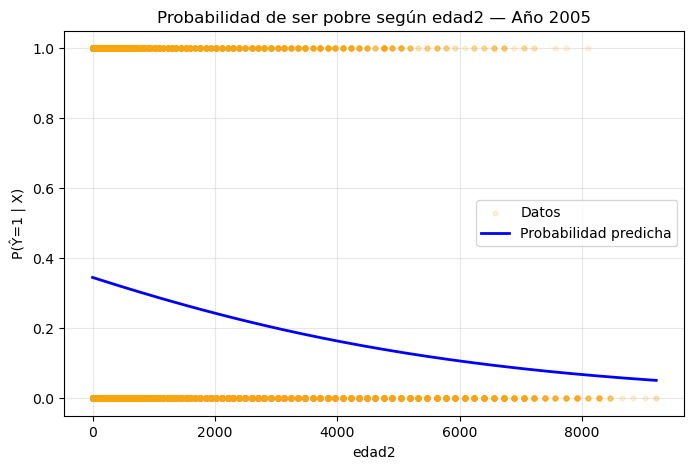

In [17]:
# Elegí año y variable numérica
año = 2005          
var_numerica = "edad2"   

# Modelo y X_train del punto 3
modelo  = resultados_logit[año]["res"]
X_train = train_dict[año]["X_train"].copy()
y_train = train_dict[año]["y_train"].copy()

# 1) Grilla de valores para la variable numérica
x_vals = np.linspace(X_train[var_numerica].min(), X_train[var_numerica].max(), 200)

# 2) Base de predicción: todas las X en su media y sólo var_numerica variando
row_mean = X_train.mean(numeric_only=True)
X_pred = pd.DataFrame([row_mean.values]*len(x_vals), columns=row_mean.index)
X_pred[var_numerica] = x_vals

# 3) Agregar constante y ALINEAR columnas con el modelo
X_pred = sm.add_constant(X_pred, has_constant="add")
for col in modelo.params.index:
    if col not in X_pred.columns:
        X_pred[col] = 0
X_pred = X_pred[modelo.params.index]  # mismo orden de columnas que el modelo

# 4) Probabilidad predicha
p_hat = modelo.predict(X_pred)

# 5) Gráfico tipo clase
plt.figure(figsize=(8,5))
plt.scatter(X_train[var_numerica], y_train, alpha=0.15, s=12, label="Datos", color="orange")
plt.plot(x_vals, p_hat, linewidth=2, label="Probabilidad predicha", color="blue")
plt.title(f"Probabilidad de ser pobre según {var_numerica} — Año {año}")
plt.xlabel(var_numerica)
plt.ylabel("P(Ŷ=1 | X)")
plt.ylim(-0.05, 1.05)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

### 2025

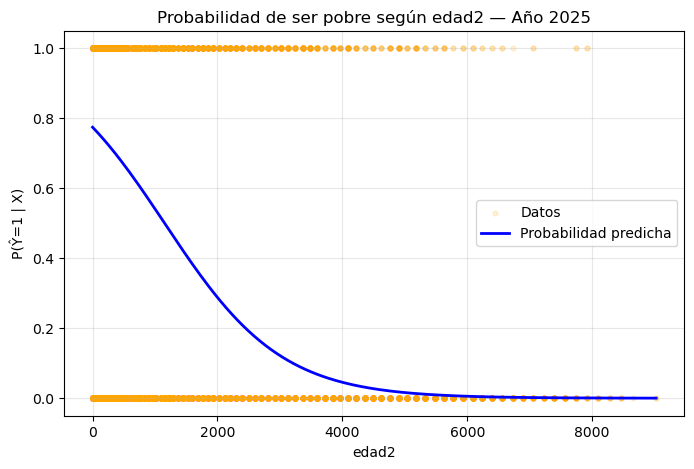

In [18]:
# Elegí año y variable numérica
año = 2025          
var_numerica = "edad2"   

# Modelo y X_train del punto 3
modelo  = resultados_logit[año]["res"]
X_train = train_dict[año]["X_train"].copy()
y_train = train_dict[año]["y_train"].copy()

# 1) Grilla de valores para la variable numérica
x_vals = np.linspace(X_train[var_numerica].min(), X_train[var_numerica].max(), 200)

# 2) Base de predicción: todas las X en su media y sólo var_numerica variando
row_mean = X_train.mean(numeric_only=True)
X_pred = pd.DataFrame([row_mean.values]*len(x_vals), columns=row_mean.index)
X_pred[var_numerica] = x_vals

# 3) Agregar constante y ALINEAR columnas con el modelo
X_pred = sm.add_constant(X_pred, has_constant="add")
for col in modelo.params.index:
    if col not in X_pred.columns:
        X_pred[col] = 0
X_pred = X_pred[modelo.params.index]  # mismo orden de columnas que el modelo

# 4) Probabilidad predicha
p_hat = modelo.predict(X_pred)

# 5) Gráfico tipo clase
plt.figure(figsize=(8,5))
plt.scatter(X_train[var_numerica], y_train, alpha=0.15, s=12, label="Datos", color="orange")
plt.plot(x_vals, p_hat, linewidth=2, label="Probabilidad predicha", color="blue")
plt.title(f"Probabilidad de ser pobre según {var_numerica} — Año {año}")
plt.xlabel(var_numerica)
plt.ylabel("P(Ŷ=1 | X)")
plt.ylim(-0.05, 1.05)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# C. Metodos de vecinos cercanos KNN

## Punto 5

In [19]:
def eval_knn_con_split(X_train, X_test, y_train, y_test, ks=(1,5,10)):
    resultados = []
    for k in ks:
        pipe = Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("scl", StandardScaler()),
            ("knn", KNeighborsClassifier(n_neighbors=k))
        ])
        pipe.fit(X_train, y_train)

        y_pred  = pipe.predict(X_test)
        y_proba = pipe.predict_proba(X_test)[:, 1]

        resultados.append({
            "k": k,
            "accuracy": accuracy_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred, zero_division=0),
            "roc_auc": roc_auc_score(y_test, y_proba),
            "cm": confusion_matrix(y_test, y_pred)
        })
    return resultados


for año in [2005, 2025]:
    X_train = train_dict[año]["X_train"]
    X_test  = train_dict[año]["X_test"]
    y_train = train_dict[año]["y_train"]
    y_test  = train_dict[año]["y_test"]

    print(f"\n== Año {año} ==")
    res = eval_knn_con_split(X_train, X_test, y_train, y_test, ks=(1,5,10))
    for r in res:
        print(f"K={r['k']} | Acc={r['accuracy']:.3f} | F1={r['f1']:.3f} | ROC-AUC={r['roc_auc']:.3f}")
        print("Matriz de confusión:\n", r["cm"])


== Año 2005 ==
K=1 | Acc=0.693 | F1=0.463 | ROC-AUC=0.623
Matriz de confusión:
 [[2437  635]
 [ 697  575]]
K=5 | Acc=0.729 | F1=0.464 | ROC-AUC=0.724
Matriz de confusión:
 [[2656  416]
 [ 762  510]]
K=10 | Acc=0.747 | F1=0.429 | ROC-AUC=0.755
Matriz de confusión:
 [[2829  243]
 [ 858  414]]

== Año 2025 ==
K=1 | Acc=0.680 | F1=0.543 | ROC-AUC=0.648
Matriz de confusión:
 [[1374  446]
 [ 450  532]]
K=5 | Acc=0.722 | F1=0.581 | ROC-AUC=0.771
Matriz de confusión:
 [[1483  337]
 [ 442  540]]
K=10 | Acc=0.734 | F1=0.557 | ROC-AUC=0.792
Matriz de confusión:
 [[1591  229]
 [ 515  467]]


## Punto 6

### 2005

/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


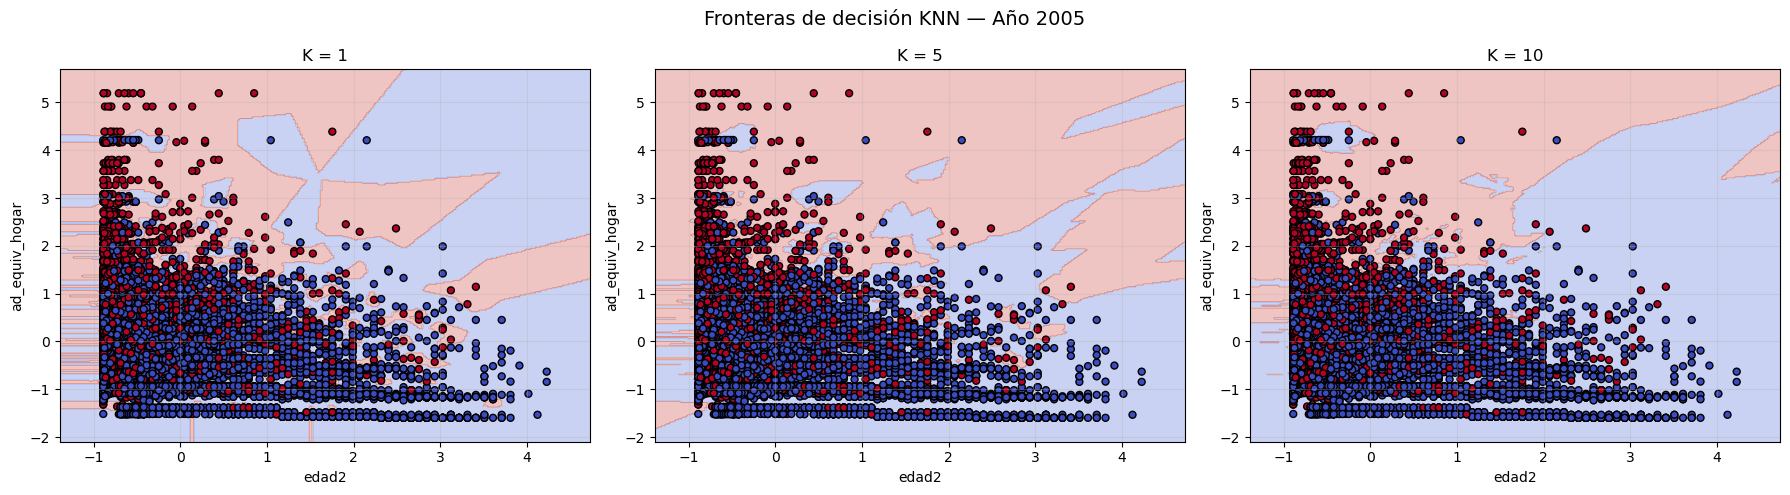

In [21]:
año = 2005
var_x = "edad2"
var_y = "ad_equiv_hogar"

X_train = train_dict[año]["X_train"][[var_x, var_y]].copy()
y_train = train_dict[año]["y_train"].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

x_min, x_max = X_scaled[:, 0].min() - 0.5, X_scaled[:, 0].max() + 0.5
y_min, y_max = X_scaled[:, 1].min() - 0.5, X_scaled[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, k in zip(axes, [1, 5, 10]):
    pipe = Pipeline([
        ("scl", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    pipe.fit(X_train, y_train)

    Z = pipe.predict(scaler.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_train,
               cmap="coolwarm", edgecolor="k", s=25)
    ax.set_title(f"K = {k}")
    ax.set_xlabel(var_x)
    ax.set_ylabel(var_y)
    ax.grid(alpha=0.3)

plt.suptitle(f"Fronteras de decisión KNN — Año {año}", fontsize=14)
plt.tight_layout()
plt.show()

### 2025

/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


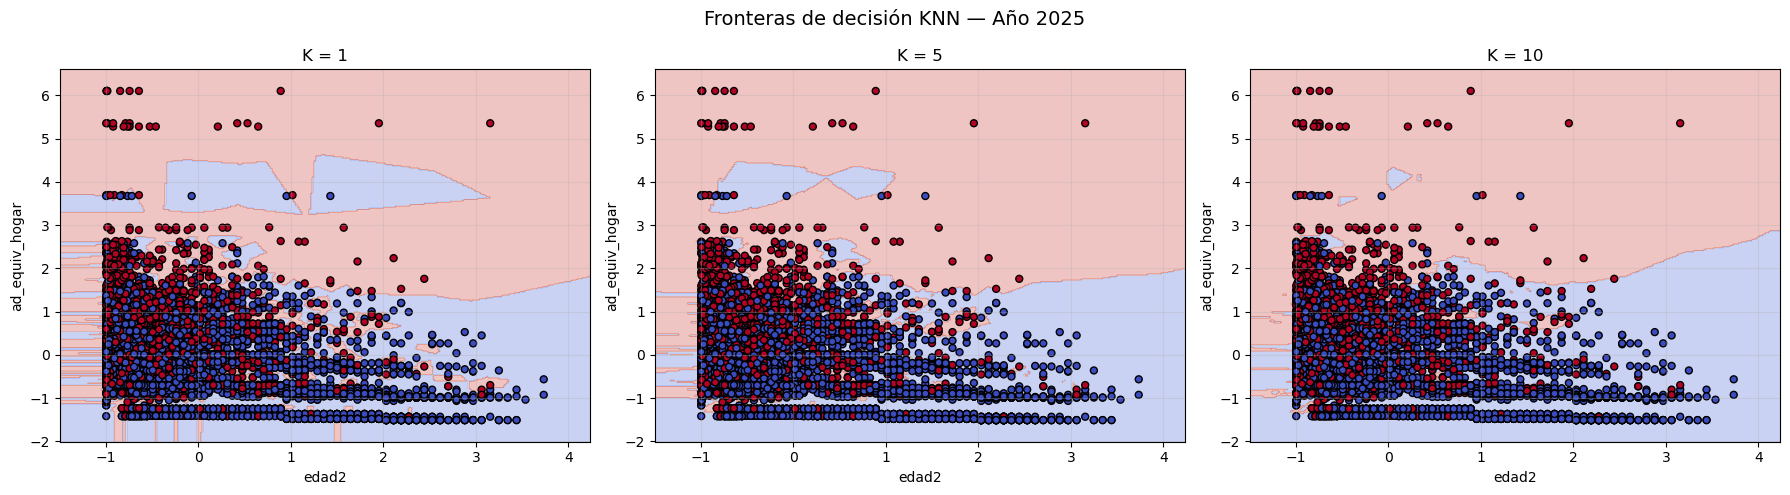

In [20]:
año = 2025
var_x = "edad2"
var_y = "ad_equiv_hogar"

X_train = train_dict[año]["X_train"][[var_x, var_y]].copy()
y_train = train_dict[año]["y_train"].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

x_min, x_max = X_scaled[:, 0].min() - 0.5, X_scaled[:, 0].max() + 0.5
y_min, y_max = X_scaled[:, 1].min() - 0.5, X_scaled[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, k in zip(axes, [1, 5, 10]):
    pipe = Pipeline([
        ("scl", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    pipe.fit(X_train, y_train)

    Z = pipe.predict(scaler.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_train,
               cmap="coolwarm", edgecolor="k", s=25)
    ax.set_title(f"K = {k}")
    ax.set_xlabel(var_x)
    ax.set_ylabel(var_y)
    ax.grid(alpha=0.3)

plt.suptitle(f"Fronteras de decisión KNN — Año {año}", fontsize=14)
plt.tight_layout()
plt.show()

## Punto 7

### 2025

K óptimo según Cross-Validation: 17


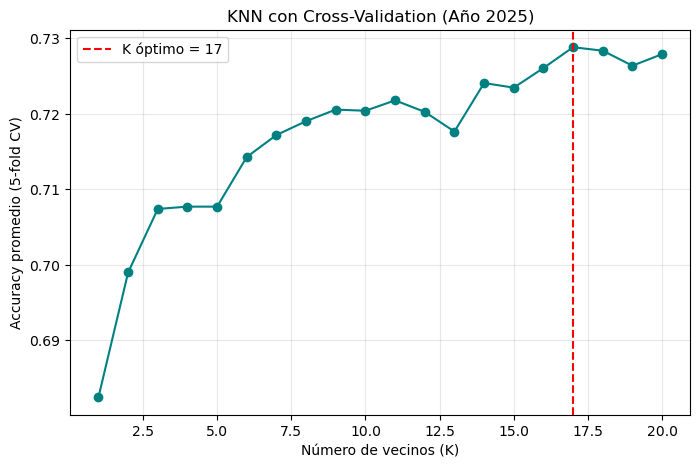

In [22]:
# Año y datos
año = 2025
X_train = train_dict[año]["X_train"].copy()
y_train = train_dict[año]["y_train"].copy()

# Rango de K a probar
k_values = range(1, 21)   # probamos de 1 a 20 vecinos

# Guardar resultados
mean_accuracies = []

# Validación cruzada en 5 partes
for k in k_values:
    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),  # estandarizamos
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    # 5-fold cross-validation (usamos accuracy como métrica)
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
    mean_accuracies.append(scores.mean())

# Identificar el K óptimo
k_optimo = k_values[np.argmax(mean_accuracies)]
print(f"K óptimo según Cross-Validation: {k_optimo}")

# --- Graficar resultados ---
plt.figure(figsize=(8,5))
plt.plot(k_values, mean_accuracies, marker='o', linestyle='-', color='teal')
plt.axvline(k_optimo, color='red', linestyle='--', label=f"K óptimo = {k_optimo}")
plt.title(f"KNN con Cross-Validation (Año {año})")
plt.xlabel("Número de vecinos (K)")
plt.ylabel("Accuracy promedio (5-fold CV)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Desempeño de modelos, eleccion y prediccion afuera de las muestras

## Punto 8

### 2025


📊 Logit
Accuracy: 0.738 | F1: 0.589 | ROC-AUC: 0.803
Matriz de confusión:
[[1542  278]
 [ 456  526]]

📊 KNN (K=17)
Accuracy: 0.740 | F1: 0.586 | ROC-AUC: 0.805
Matriz de confusión:
[[1557  263]
 [ 466  516]]


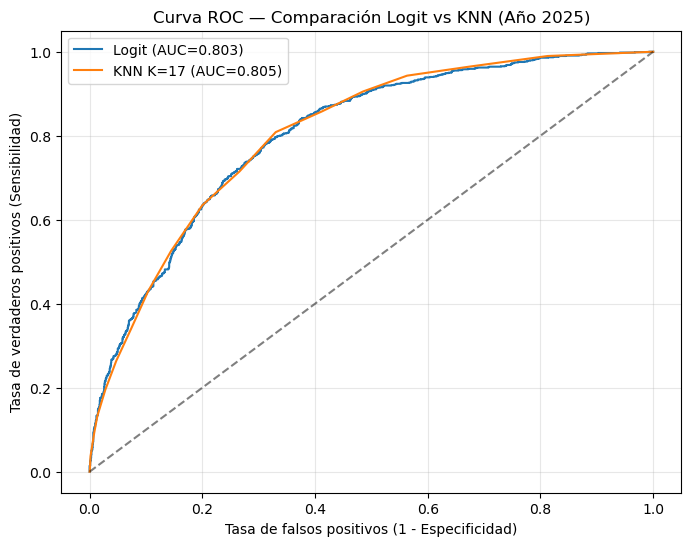

In [113]:
# --- Año de análisis ---
año = 2025

# --- Datos ---
X_train = train_dict[año]["X_train"].copy()
y_train = train_dict[año]["y_train"].copy()
X_test = train_dict[año]["X_test"].copy()
y_test = train_dict[año]["y_test"].copy()

# --- 1. MODELO LOGIT ---
import statsmodels.api as sm
X_train_log = sm.add_constant(X_train, has_constant="add")
X_test_log = sm.add_constant(X_test, has_constant="add")

logit_model = sm.Logit(y_train, X_train_log).fit(disp=False)
y_pred_prob_logit = logit_model.predict(X_test_log)
y_pred_logit = (y_pred_prob_logit > 0.5).astype(int)

# --- 2. MODELO KNN CON K-CV ---
from sklearn.neighbors import KNeighborsClassifier

k_optimo = 17  # obtenido del punto anterior
pipe_knn = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("knn", KNeighborsClassifier(n_neighbors=k_optimo))
])
pipe_knn.fit(X_train, y_train)
y_pred_knn = pipe_knn.predict(X_test)
y_pred_prob_knn = pipe_knn.predict_proba(X_test)[:, 1]

# --- 3. MÉTRICAS ---
def print_metrics(y_true, y_pred, y_prob, modelo):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    print(f"\n📊 {modelo}")
    print(f"Accuracy: {acc:.3f} | F1: {f1:.3f} | ROC-AUC: {auc:.3f}")
    print("Matriz de confusión:")
    print(confusion_matrix(y_true, y_pred))
    return acc, f1, auc

acc_l, f1_l, auc_l = print_metrics(y_test, y_pred_logit, y_pred_prob_logit, "Logit")
acc_k, f1_k, auc_k = print_metrics(y_test, y_pred_knn, y_pred_prob_knn, f"KNN (K={k_optimo})")

# --- 4. CURVAS ROC ---
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_prob_logit)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_prob_knn)

plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f"Logit (AUC={auc_l:.3f})")
plt.plot(fpr_knn, tpr_knn, label=f"KNN K={k_optimo} (AUC={auc_k:.3f})")
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.title(f"Curva ROC — Comparación Logit vs KNN (Año {año})")
plt.xlabel("Tasa de falsos positivos (1 - Especificidad)")
plt.ylabel("Tasa de verdaderos positivos (Sensibilidad)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Punto 9

### 2025

In [29]:
# --- Año de análisis ---
año = 2025

# --- Datos ---
X_train = train_dict[año]["X_train"].copy()
y_train = train_dict[año]["y_train"].copy()
X_test = train_dict[año]["X_test"].copy()
y_test = train_dict[año]["y_test"].copy()

# --- MODELO LOGIT ---
import statsmodels.api as sm
X_train_log = sm.add_constant(X_train, has_constant="add")
X_test_log = sm.add_constant(X_test, has_constant="add")

logit_model = sm.Logit(y_train, X_train_log).fit(disp=False)
y_pred_prob_logit = logit_model.predict(X_test_log)
y_pred_logit = (y_pred_prob_logit > 0.5).astype(int)

# --- MODELO KNN CON K=20 ---
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve

k_optimo = 17  # obtenido por Cross-Validation

pipe_knn = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("knn", KNeighborsClassifier(n_neighbors=k_optimo))
])

pipe_knn.fit(X_train, y_train)
y_pred_knn = pipe_knn.predict(X_test)
y_pred_prob_knn = pipe_knn.predict_proba(X_test)[:, 1]

# --- FUNCIÓN DE ERRORES TIPO I Y II ---
def errores_tipo(conf_mat):
    tn, fp, fn, tp = conf_mat.ravel()
    tipo_I = fp / (fp + tn)     # Falsos positivos
    tipo_II = fn / (fn + tp)    # Falsos negativos
    return tipo_I, tipo_II

# --- Calcular errores ---
cm_log = confusion_matrix(y_test, y_pred_logit)
cm_knn = confusion_matrix(y_test, y_pred_knn)

tipoI_log, tipoII_log = errores_tipo(cm_log)
tipoI_knn, tipoII_knn = errores_tipo(cm_knn)

# --- Tabla comparativa ---
pd.DataFrame({
    "Modelo": ["Logit", f"KNN (K={k_optimo})"],
    "Error Tipo I (FP)": [tipoI_log, tipoI_knn],
    "Error Tipo II (FN)": [tipoII_log, tipoII_knn]
}).round(3)


,Modelo,Error Tipo I (FP),Error Tipo II (FN)
0,Logit,0.153,0.464
1,KNN (K=17),0.145,0.475


A partir de los resultados obtenidos, el modelo Logit presenta un error tipo I (falsos positivos) de 0.153 y un error tipo II (falsos negativos) de 0.464, mientras que el KNN (K=17) reduce levemente el error tipo I (0.145) pero aumenta el error tipo II (0.475).
En el contexto del Ministerio de Capital Humano, el costo social de un error tipo II es considerablemente mayor, ya que implica excluir del programa a un hogar realmente pobre. Por el contrario, un error tipo I solo implicaría destinar recursos a alguien que no los necesita, lo cual es menos grave en términos sociales.
Por lo tanto, aunque el KNN con K-CV (K=17) tiene una leve mejora en rendimiento general (ROC-AUC = 0.805 vs. 0.803 del Logit), el modelo Logit resulta más adecuado para la política pública:
Permite ajustar el umbral de clasificación para reducir los falsos negativos.
Ofrece mayor transparencia e interpretabilidad, clave para justificar decisiones de asignación de recursos.
En conclusión, el modelo Logit sería la mejor elección para este objetivo, ya que prioriza la inclusión y minimiza el riesgo de dejar fuera a los hogares vulnerables, aunque esto implique un leve aumento de los falsos positivos.

## Punto 10

### 2025

In [117]:
# ---------- 1) Utilidades ----------
def make_design(df_raw, cols_model, X_train_2025):
    """Devuelve un diseño con EXACTAMENTE las columnas del modelo (sin 'const'),
    rellenando faltantes/NaN/Inf con la MEDIANA de train, y agrega 'const'."""
    X = pd.DataFrame(index=df_raw.index)
    for c in cols_model:
        if c in df_raw.columns:
            col = pd.to_numeric(df_raw[c], errors="coerce")
        else:
            col = pd.Series(np.nan, index=df_raw.index)
        # mediana de train para esa columna
        med = pd.to_numeric(X_train_2025[c], errors="coerce").median()
        X[c] = col.replace([np.inf, -np.inf], np.nan).fillna(med)
    X = sm.add_constant(X, has_constant="add")
    # ordenar exactamente como el modelo
    return X[["const"] + cols_model]

# ---------- 2) Preparación (año 2025) ----------
año = 2025
X_train_2025 = train_dict[año]["X_train"].copy()
y_train_2025 = train_dict[año]["y_train"].copy()
X_test_2025  = train_dict[año]["X_test"].copy()
y_test_2025  = train_dict[año]["y_test"].copy()

# columnas del modelo (sin 'const')
cols_model = [c for c in logit_model.params.index if c != "const"]

# Matrices de test alineadas (por si todavía no las tenías así)
X_test_log = make_design(X_test_2025, cols_model, X_train_2025)
p_test = logit_model.predict(X_test_log)

# ---------- 3) Umbral óptimo en TEST (Youden-J) ----------
fpr, tpr, th = roc_curve(y_test_2025, p_test)
j = tpr - fpr
thr_opt = th[np.argmax(j)]

# ---------- 4) Predicción en NO RESPONDIERON 2025 ----------
norespondieron_2025 = df_norespondieron[df_norespondieron["ANO4"] == 2025].copy()

X_nr = make_design(norespondieron_2025, cols_model, X_train_2025)
p_nr = logit_model.predict(X_nr)

# Proporciones con umbral 0.5 y con umbral óptimo
prop_05   = (p_nr > 0.5).mean()
prop_opt  = (p_nr > thr_opt).mean()

print(f"Diagnóstico probabilidades NORESP 2025 -> mean: {p_nr.mean():.3f} | min: {p_nr.min():.3f} | max: {p_nr.max():.3f}")
print(f"Total observaciones norespondieron_2025 usadas: {len(p_nr)}")
print(f"Umbral óptimo (Youden-J) en TEST: {thr_opt:.3f}")
print(f"Proporción 'pobres' con p>0.5:   {prop_05:.3f}")
print(f"Proporción 'pobres' con p>{thr_opt:.3f}: {prop_opt:.3f}")

Diagnóstico probabilidades NORESP 2025 -> mean: 0.292 | min: 0.005 | max: 0.616
Total observaciones norespondieron_2025 usadas: 4463
Umbral óptimo (Youden-J) en TEST: 0.336
Proporción 'pobres' con p>0.5:   0.071
Proporción 'pobres' con p>0.336: 0.335
